In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision.transforms as transforms

from lib.dataset import CustomDataset
from lib.trainer import Trainer

### Plot data

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train = df.values[:,0]
X_train = np.reshape(df.values[:,1:], (-1, 1, 28, 28))
X_train = X_train.transpose((0, 2, 3, 1)) # PIL format

In [5]:
X_train.shape

(42000, 28, 28, 1)

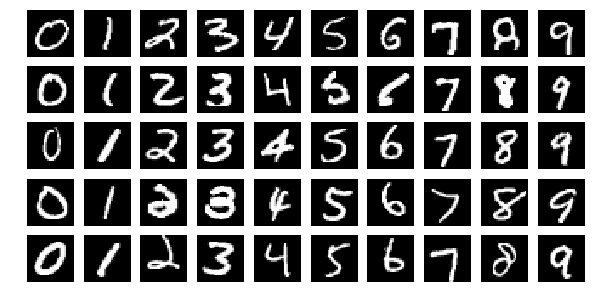

In [8]:
fig, axes = plt.subplots(5, 10, figsize=(10,5))
for i in range(10): # classes
    examples = X_train[np.random.choice(np.where(y_train == i)[0], size=5)]
    for j in range(5): # samples
        axes[j,i].imshow(examples[j].reshape(28,28), cmap='gray')
        axes[j,i].set_axis_off()

#plt.show()
plt.savefig('img/1.png')

### Define Model

In [6]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.pad1 = nn.ConstantPad2d(1, 0)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(2)
        
        self.pad2 = nn.ConstantPad2d(1, 0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.pad3 = nn.ConstantPad2d(1, 0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(128*7*7, 400)
        self.fc2 = nn.Linear(400, 10)
        
    def forward(self, x):
        x = self.pad1(x)
        x = f.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = self.pad2(x)
        x = f.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = self.pad3(x)
        x = f.relu(self.conv3(x))
        
        x = x.view(-1, 128*7*7)
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

### Setup dataset

In [7]:
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = CustomDataset(X_train, y_train, t)

### Train model for five epochs

In [8]:
model = CNN()
args = {
    "lr": 1e-4,
    "betas": (0.9, 0.999),
    "eps": 1e-8,
    "weight_decay": 0.0
}
trainer = Trainer(model, dataset, batch_size=128, epochs=5, log_nth=None, num_workers=0, optim_args=args)
trainer.train()

Start training...
[FINISHED EPOCH 0] TRAIN ACC/LOSS: 0.984375/0.03377899155020714
[FINISHED EPOCH 0] VAL acc/loss: 0.9708570075757574/0.09451562911272049

[FINISHED EPOCH 1] TRAIN ACC/LOSS: 0.984375/0.06351763755083084
[FINISHED EPOCH 1] VAL acc/loss: 0.9842329545454545/0.05178083851933479

[FINISHED EPOCH 2] TRAIN ACC/LOSS: 0.96875/0.14069603383541107
[FINISHED EPOCH 2] VAL acc/loss: 0.9847774621212121/0.05024981126189232

[FINISHED EPOCH 3] TRAIN ACC/LOSS: 0.984375/0.040779128670692444
[FINISHED EPOCH 3] VAL acc/loss: 0.9779829545454546/0.0728532075881958

[FINISHED EPOCH 4] TRAIN ACC/LOSS: 1.0/0.0007656663656234741
[FINISHED EPOCH 4] VAL acc/loss: 0.9859611742424242/0.05139361321926117

Finished training.


### Test model

In [9]:
df = pd.read_csv("../data/test.csv")
X_test = np.reshape(df.values, (-1, 1, 28, 28))
X_test = X_test.transpose((0, 2, 3, 1)) # PIL format

In [10]:
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean and standard deviation
])
test_dataset = CustomDataset(X_test, [None for _ in X_test], t, test=True)

3

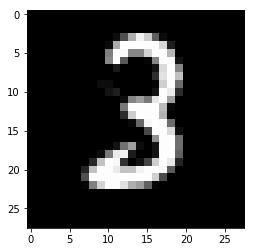

In [20]:
i = 4
model = model.cpu()
plt.imshow(test_dataset[i][0], cmap='gray')
pred = model(test_dataset[i].unsqueeze(0)).detach().numpy()
pred.argmax()

In [21]:
# prepare kaggle submission
out = []
for i, x in enumerate(test_dataset):
    pred = model(test_dataset[i].unsqueeze(0)).detach().numpy()
    pred = pred.argmax()
    out.append([i+1, int(pred)])

In [22]:
df = pd.DataFrame(out, columns=['ImageId', 'Label'])

In [23]:
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [12]:
df.to_csv('test.csv', index=False)
# when trained with more epochs, this model currently reaches a score of 0.9914 on kaggle